### K-means Clustering의 이해
- 각 군집에 할당된 포인트들의 평균좌표를 이용해 중심점을 반복해서 업데이트 하는 방법
- 알고리즘 수행 절차
    1. k개의 중심 좌표 생성
    1. 각 데이터와 중심 좌표 사이의 거리를 계산하여 가까운 중심 좌표로 군집을 할당
    1. 할당된 군집을 기반으로 새로운 중심 좌표를 계산
    1. 모든 데이터의 클러스터 할당이 바뀌지 않을때까지 반복

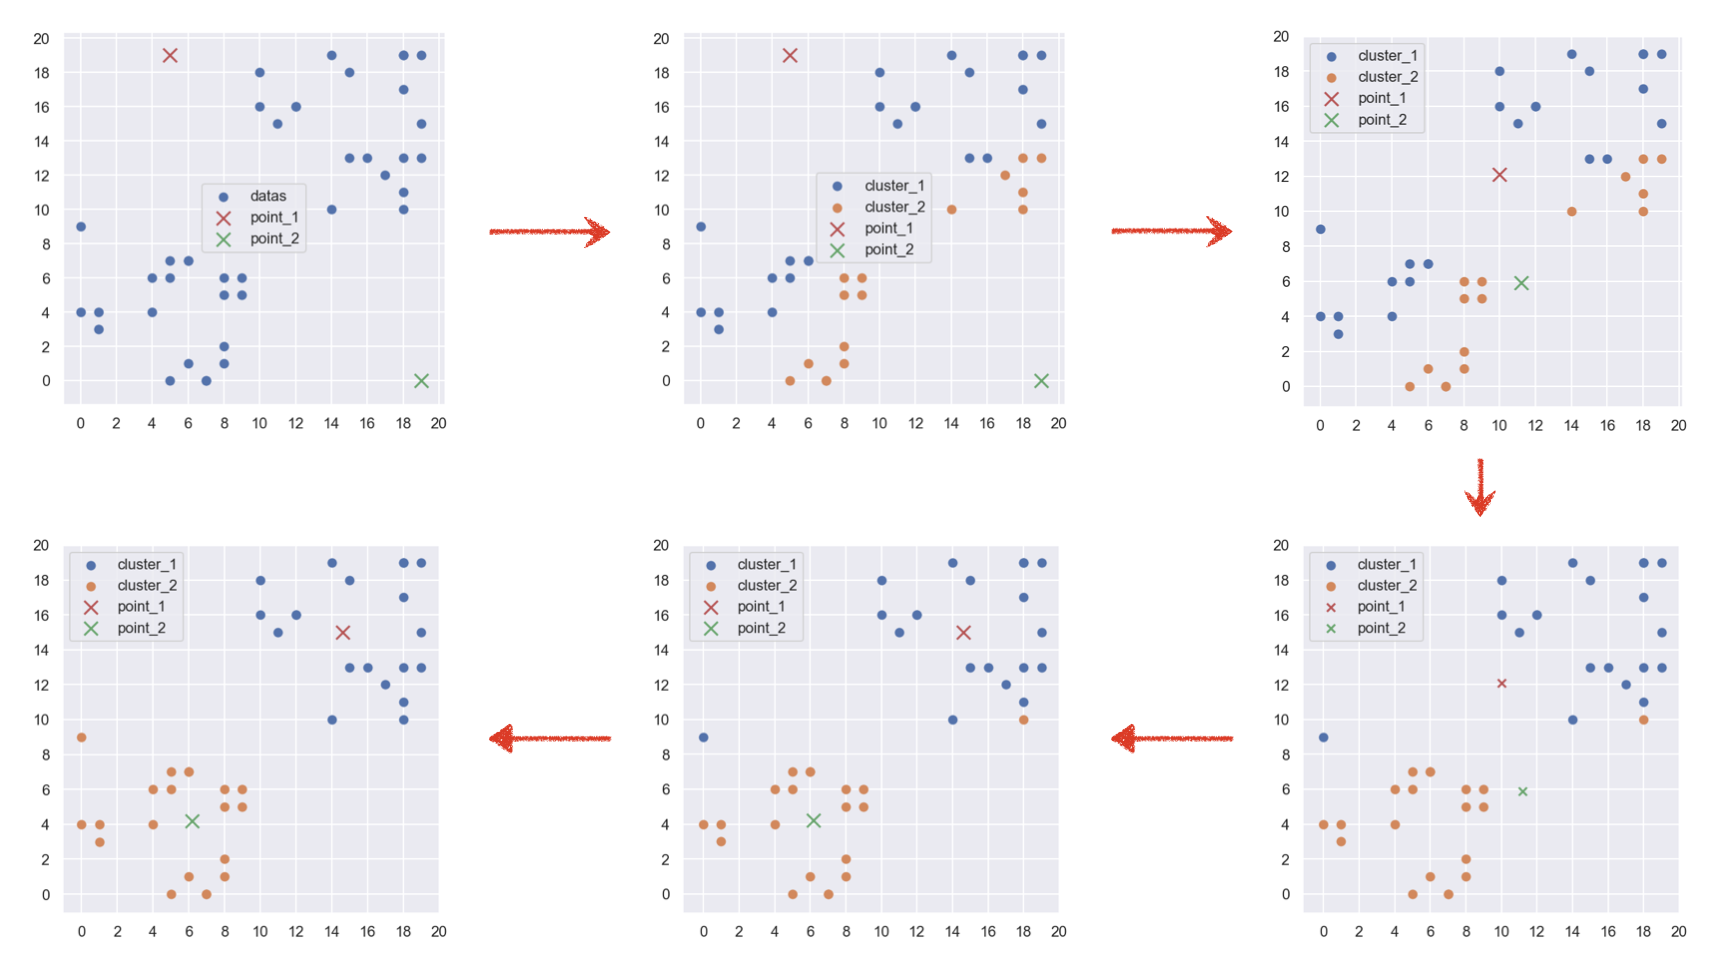

In [1]:
from IPython.display import Image
Image('./imgs/k_means_1.png') # iteration

#### 1. 샘플 데이터 생성

In [2]:
import numpy as np
import pandas as pd

In [3]:
# 1. 두개의 카테고리 데이터 생성
np.random.seed(0)
datas_1 = np.random.randint(0, 10, size=(20, 2)) # 0 ~ 19까지 랜덤한 수를 생성
datas_2 = np.random.randint(10, 20, size=(20, 2)) # 0 ~ 19까지 랜덤한 수를 생성
print(datas_1, datas_2)

[[5 0]
 [3 3]
 [7 9]
 [3 5]
 [2 4]
 [7 6]
 [8 8]
 [1 6]
 [7 7]
 [8 1]
 [5 9]
 [8 9]
 [4 3]
 [0 3]
 [5 0]
 [2 3]
 [8 1]
 [3 3]
 [3 7]
 [0 1]] [[19 19]
 [10 14]
 [17 13]
 [12 17]
 [12 10]
 [10 14]
 [15 15]
 [16 18]
 [14 11]
 [14 19]
 [18 11]
 [11 17]
 [19 19]
 [13 16]
 [17 12]
 [10 13]
 [15 19]
 [14 14]
 [16 14]
 [14 13]]


In [4]:
# ndarray를 dataframe으로 변경
df_1 = pd.DataFrame(datas_1, columns=["x", "y"])
df_2 = pd.DataFrame(datas_2, columns=["x", "y"])
df_1.head()

,x,y
0,5,0
1,3,3
2,7,9
3,3,5
4,2,4


In [5]:
# 데이터의 클러스터 분리
df_1["cluster"], df_2["cluster"] = 1, 2

# 모든 데이터
df_datas = pd.concat([df_1, df_2]).reset_index(drop=True)

df_datas.tail(2)

,x,y,cluster
38,16,14,2
39,14,13,2


In [7]:
%config InlineBackend.figure_formats = {'png', 'retina'}

import matplotlib as mpl
import matplotlib.pyplot as plt

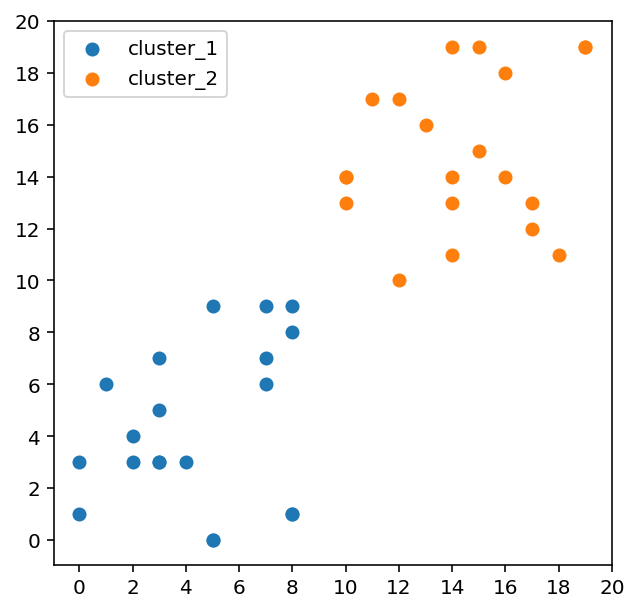

In [8]:
# 2. 샘플 데이터 산점도

# 그래프 크기 설정
plt.figure(figsize=(5, 5))

# 클러스터 1 데이터
plt.scatter(df_1["x"], df_1["y"], label="cluster_1")

# 클러스터 2 데이터
plt.scatter(df_2["x"], df_2["y"], label="cluster_2")

# x, y ticks 설정
plt.xticks(range(0, 21, 2))
plt.yticks(range(0, 21, 2))

# 데이터 label 출력
plt.legend()

# 그래프 출력
plt.show()

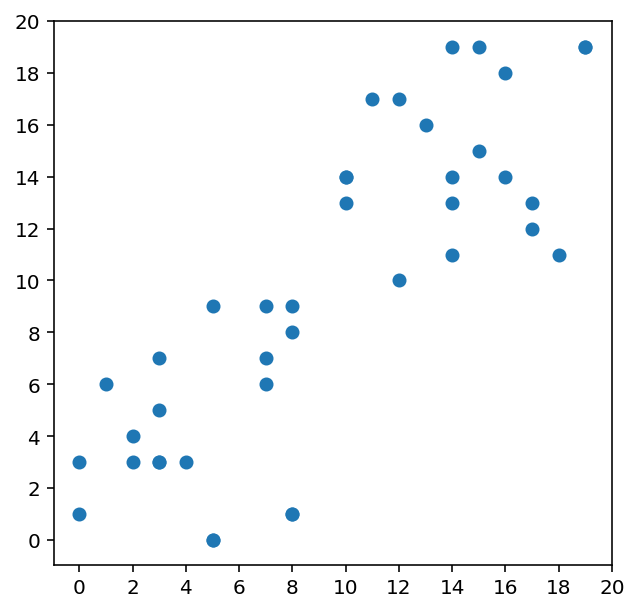

In [9]:
# 3. 전체 데이터 산점도

# 그래프 크기 설정
plt.figure(figsize=(5, 5))

# 모든 데이터
plt.scatter(df_datas["x"], df_datas["y"])

# x, y ticks 설정
plt.xticks(range(0, 21, 2))
plt.yticks(range(0, 21, 2))

plt.show()

#### 2. k개의 중심 좌표 생성
- k개의 갯수만큼 랜덤한 point 생성

In [11]:
# 4. 랜덤한 중심 좌표 생성

# 랜덤 포인트 출력해주는 함수
def random_point(df_datas, random_state=0):
    
    # random seed 설정
    np.random.seed(random_state)
    
    # x의 최소값과 최대값 사이에서 랜덤한 값을 선택
    point_x = np.random.randint(df_datas["x"].min(), df_datas["x"].max())
    
    # y의 최소값과 최대값 사이에서 랜덤한 값을 선택
    point_y = np.random.randint(df_datas["y"].min(), df_datas["y"].max())
    
    # 랜덤한 x, y 값을 ndarray로 리턴
    return np.array([point_x, point_y])    

# 2개의 랜덤한 포인트 생성
point_1 = random_point(df_datas, 5)
point_2 = random_point(df_datas, 7)

# 랜덤한 포인트 출력
print(point_1, point_2)

[ 3 14] [15  4]


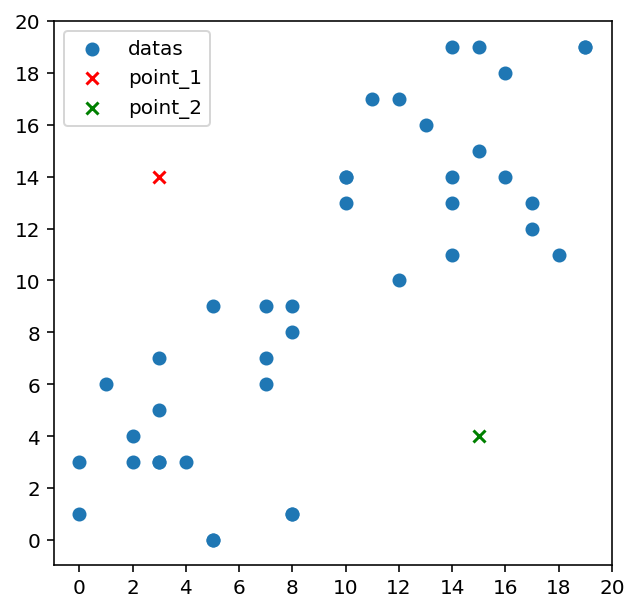

In [12]:
# 5. 중심 좌표를 추가한 산점도

# 그래프 크기 설정
plt.figure(figsize=(5, 5))

# 모든 데이터 출력
plt.scatter(df_datas["x"], df_datas["y"], label="datas")

# 랜덤 포인트 1
plt.scatter(point_1[0], point_1[1], c="r", marker="x", label="point_1")

# 랜덤 포인트 2
plt.scatter(point_2[0], point_2[1], c="g", marker="x", label="point_2")

# x, y ticks 설정
plt.xticks(range(0, 21, 2))
plt.yticks(range(0, 21, 2))

# 데이터 label 출력
plt.legend()

# 그래프 출력
plt.show()

In [13]:
# 6. 두개의 점에서 가까운 중심 좌표로 클러스터링

# 거리를 구해주는 모듈 호출
from scipy.spatial import distance

# 데이터 프레임 만들기
df = pd.DataFrame(columns=["x", "y", "dist_1", "dist_2", "cluster"])

# 모든 데이터에 대해 클러스터를 결정하기 위한 반복문
for idx, data in df_datas.iterrows():
    
    # 거리 구하기
    dist_1 = np.round(distance.euclidean(point_1, [data.x, data.y]), 1)
    dist_2 = np.round(distance.euclidean(point_2, [data.x, data.y]), 1)
    
    # 클러스터 결정 : dist_1에 가까우면 1, dist_2에 가까운면 2 로 클러스터 결정
    cluster = 1 if dist_1 <= dist_2 else 2
    
    # 결과를 데이터 프레임으로 만들기
    df.loc[idx] = {"x": data.x, "y": data.y, "dist_1": dist_1, "dist_2": dist_2, "cluster": cluster}
    
df.tail(2)

,x,y,dist_1,dist_2,cluster
38,16,14,13.0,10.0,2
39,14,13,11.0,9.1,2


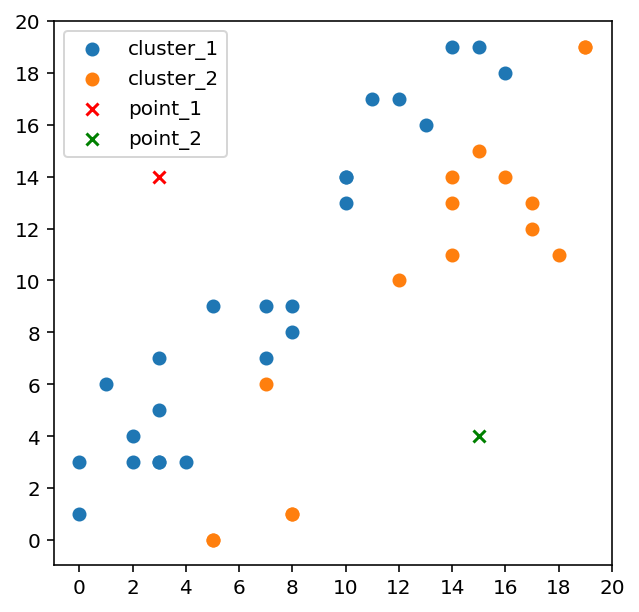

In [14]:
# 7. 1회 클러스터링한 산점도

# 데이터에 대한 클러스터 분리
df_c_1 = df[df["cluster"] == 1]
df_c_2 = df[df["cluster"] == 2]

# 그래프 크기 설정
plt.figure(figsize=(5, 5))

# 클러스터 1 데이터 산점도 그리기
plt.scatter(df_c_1["x"], df_c_1["y"], label="cluster_1")

# 클러스터 2 데이터 산점도 그리기
plt.scatter(df_c_2["x"], df_c_2["y"], label="cluster_2")

# 랜덤 포인트 1 산점도 그리기
plt.scatter(point_1[0], point_1[1], c="r", marker="x", label="point_1")

# 랜덤 포인트 2 산점도 그리기
plt.scatter(point_2[0], point_2[1], c="g", marker="x", label="point_2")

# x, y ticks 설정
plt.xticks(range(0, 21, 2))
plt.yticks(range(0, 21, 2))

# 데이터 label 출력
plt.legend()

plt.show()

이전 랜덤 포인트 : [ 3 14] [15  4]
새로운 랜덤 포인트 : [7.  9.5] [13.   9.9]


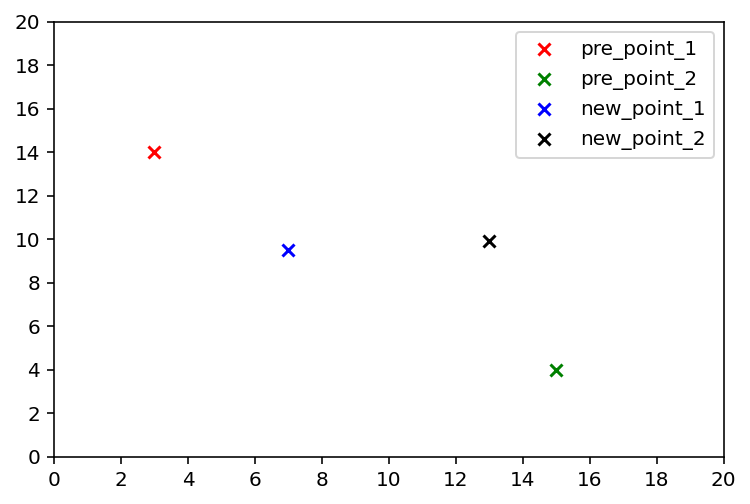

In [15]:
# 8. 클러스터링한 데이터의 중심점으로 중심 좌표 수정

# 이전 포인트 데이터 복사
pre_point_1 = point_1.copy()
pre_point_2 = point_2.copy()

# 데이터에 대한 클러스터 분리
df_c_1 = df[df["cluster"] == 1]
df_c_2 = df[df["cluster"] == 2]

# 클러스터 1 데이터의 평균값으로 포인트 설정
point_1 = df_c_1[["x", "y"]].mean().round(1).values 

# 클러스터 2 데이터의 평균값으로 포인트 설정
point_2 = df_c_2[["x", "y"]].mean().round(1).values

# 포인트 데이터 출력
print("이전 랜덤 포인트 :", pre_point_1, pre_point_2)
print("새로운 랜덤 포인트 :", point_1, point_2)

# 이전 랜덤 포인트 1 산점도 그리기
plt.scatter(pre_point_1[0], pre_point_1[1], c="r", marker="x", label="pre_point_1")

# 이전 랜덤 포인트 2 산점도 그리기
plt.scatter(pre_point_2[0], pre_point_2[1], c="g", marker="x", label="pre_point_2")

# 새로운 랜덤 포인트 1 산점도 그리기
plt.scatter(point_1[0], point_1[1], c="b", marker="x", label="new_point_1")

# 새로운 랜덤 포인트 2 산점도 그리기
plt.scatter(point_2[0], point_2[1], c="black", marker="x", label="new_point_2")

# x, y ticks 설정
plt.xticks(range(0, 21, 2))
plt.yticks(range(0, 21, 2))

# 라벨 출력
plt.legend()

plt.show()

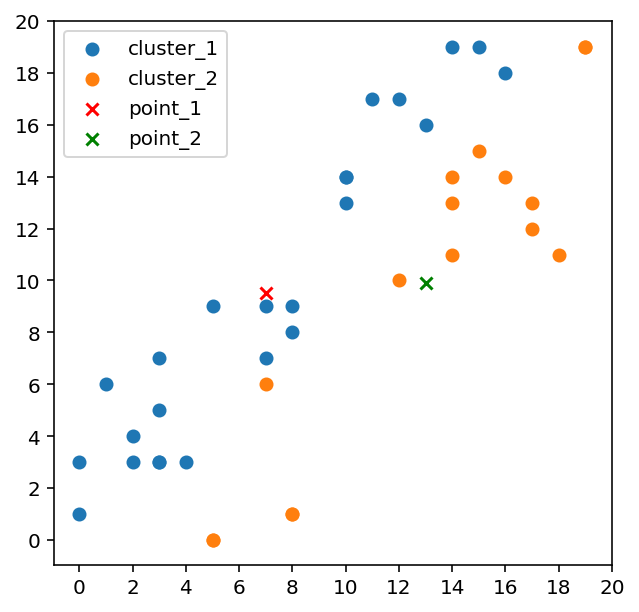

In [16]:
# 9. 새로운 포인트에 대한 산점도

# 데이터에 대한 클러스터 분리
df_c_1 = df[df["cluster"] == 1]
df_c_2 = df[df["cluster"] == 2]

# 그래프 크기 설정
plt.figure(figsize=(5, 5))

# 클러스터 1 데이터 산점도 그리기
plt.scatter(df_c_1["x"], df_c_1["y"], label="cluster_1")

# 클러스터 2 데이터 산점도 그리기
plt.scatter(df_c_2["x"], df_c_2["y"], label="cluster_2")

# 랜덤 포인트 1 산점도 그리기
plt.scatter(point_1[0], point_1[1], c="r", marker="x", label="point_1")

# 랜덤 포인트 2 산점도 그리기
plt.scatter(point_2[0], point_2[1], c="g", marker="x", label="point_2")

# x, y ticks 설정
plt.xticks(range(0, 21, 2))
plt.yticks(range(0, 21, 2))

# 라벨 출력
plt.legend()

plt.show()

In [17]:
# 10. 새로운 포인트로 클러스터링 : 데이터의 클러스터 변경이 없을때까지 아래 코드 반복 : 2번 실행
df_datas = df.copy()

df = pd.DataFrame(columns=["x", "y", "dist_1", "dist_2", "cluster"])

cluster_change_count = 0

for idx, data in df_datas.iterrows():
    
    # 이전 클러스터
    pre_cluster = data.cluster
    
    # 클러스터 결정 : dist_1에 가까우면 1, dist_2에 가까운면 2 로 클러스터 결정
    dist_1 = np.round(distance.euclidean(point_1, [data.x, data.y]), 1)
    dist_2 = np.round(distance.euclidean(point_2, [data.x, data.y]), 1)
    
    # 클러스터 결정
    new_cluster = 1 if dist_1 <= dist_2 else 2
    
    # 클러스터 변경 카운트
    cluster_change_count += 1 if pre_cluster != new_cluster else 0
    
    # 데이터 프레임으로 만들기
    df.loc[idx] = {"x": data.x, "y": data.y, "dist_1": dist_1, "dist_2": dist_2, "cluster": new_cluster}

# 클러스터가 변경된 횟수 출력
print(point_1, point_2)
print("cluster_change_count :", cluster_change_count)
    
df.head(10)

[7.  9.5] [13.   9.9]
cluster_change_count : 14


,x,y,dist_1,dist_2,cluster
0,5,0,9.7,12.7,1
1,3,3,7.6,12.1,1
2,7,9,0.5,6.1,1
3,3,5,6.0,11.1,1
4,2,4,7.4,12.5,1
5,7,6,3.5,7.2,1
6,8,8,1.8,5.3,1
7,1,6,6.9,12.6,1
8,7,7,2.5,6.7,1
9,8,1,8.6,10.2,1


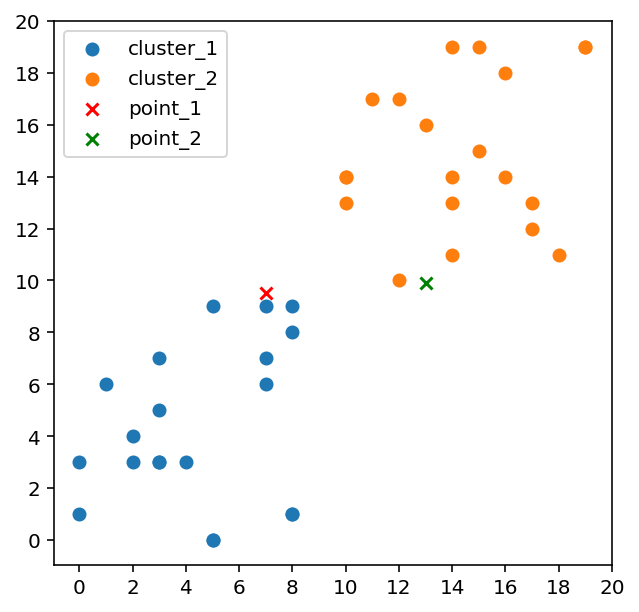

In [18]:
# 11. 변경된 산점도 확인 
# 7. 산점도와 비교
# cluster_change_count 가 0 보다 크면 -> 8. 클러스터링한 데이터의 중심점으로 포인트 수정
# cluster_change_count 가 0 이면 클로스터링 종료

# 클러스터 1과 클러스터 2 데이터 분리
df_c_1 = df[df["cluster"] == 1]
df_c_2 = df[df["cluster"] == 2]

plt.figure(figsize=(5, 5))

# 클러스터 1 데이터 
plt.scatter(df_c_1["x"], df_c_1["y"], label="cluster_1")

# 클러스터 2 데이터 
plt.scatter(df_c_2["x"], df_c_2["y"], label="cluster_2")

# 랜덤 포인트 1
plt.scatter(point_1[0], point_1[1], c="r", marker="x", label="point_1")

# 랜덤 포인트 2
plt.scatter(point_2[0], point_2[1], c="g", marker="x", label="point_2")

# 
plt.xticks(range(0, 21, 2))
plt.yticks(range(0, 21, 2))

plt.legend()

plt.show()

#### sklearn 사용
- n_clusters: 군집의 갯수
- init: 초기화 방법. "random"이면 무작위, "k-means++"이면 K-평균++ 방법
- n_init: 초기 중심위치 시도 횟수. 디폴트는 10이고 10개의 무작위 중심위치 목록 중 가장 좋은 값을 선택
- max_iter: 최대 반복 횟수
- random_state: 시드값

#### k-means++
- 최초 랜덤 포인트를 효율적으로 뽑는 방법
- K-평균++ 방법 : 처음 랜덤으로 뽑힌 포인트에서 가장 먼 지점에 두번째 랜덤 포인트를 설정

In [19]:
from sklearn.cluster import KMeans

In [20]:
# df_1(클러스터 1 데이터), df_2(클러스터 2 데이터) 데이터 결합
df_datas = pd.concat([df_1, df_2]).reset_index(drop=True)

# KMeans 모델 객체 생성 및 학습
model = KMeans(n_clusters=2, init="random", n_init=1, max_iter=1).fit(df_datas[["x", "y"]])

In [21]:
# 모델을 사용한 결과 예측
pred = model.predict(df_datas[["x", "y"]])
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [22]:
# 최종 클러스터 중심 좌표 출력
model.cluster_centers_

array([[13.13636364, 11.95454545],
       [ 4.77777778,  6.83333333]])

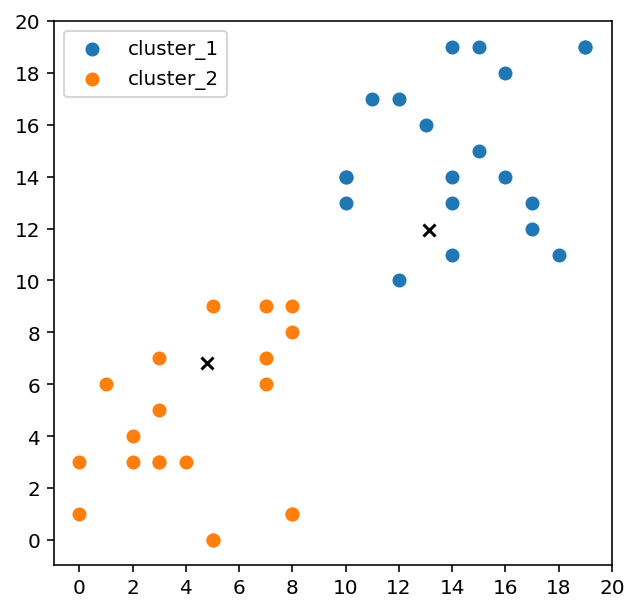

In [23]:
# 클러스터별 데이터 분리
pred_cluster_1 = df_datas[model.labels_ == 0] 
pred_cluster_2 = df_datas[model.labels_ == 1]

plt.figure(figsize=(5, 5))

# 클러스터 1 데이터 그리기
plt.scatter(pred_cluster_1["x"], pred_cluster_1["y"], label="cluster_1")

# 클러스터 2 데이터 그리기
plt.scatter(pred_cluster_2["x"], pred_cluster_2["y"], label="cluster_2")

# 클러스터 중심좌표 그리기
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], c="black", marker="x")

# x, y ticks 설정
plt.xticks(range(0, 21, 2))
plt.yticks(range(0, 21, 2))

# 라벨 출력
plt.legend()

plt.show()